In [1]:
import sys
import torch
from torch import nn
from matplotlib import pyplot as plt

sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample")
from datasets.Regression.toydataset import create_dataset, sinus_mapping, dataset_to_loader, visualize_predictions, to_loader

from src.network.feature_extractor import FC_Net
from src.network import LikApprox
from src.weight_distribution.Diagonal import Diagonal
from src.weight_distribution.Full import FullCovariance
from src.network.Regression import LLVIRegression

sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI")
from BNN_Comparison.TyXe import tyxe
from pyro import distributions as pyro_dist
import pyro
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
%matplotlib inline
from datetime import datetime
import pandas as pd

In [2]:
data_noise = 0.2
n_train_datapoints=256
n_val_datapoints=256
mapping = sinus_mapping
cluster_pos = [-0.5,2]
lower=-5
upper=7
batch_size=16


x_train, y_train, x_test, y_test = create_dataset(lower=lower, upper=upper, mapping=mapping,cluster_pos=cluster_pos, data_noise=data_noise, n_datapoints=n_train_datapoints)
x_validation, y_validation, _, _ = create_dataset(lower=lower, upper=upper, mapping=mapping,cluster_pos=cluster_pos, data_noise=data_noise, n_datapoints=n_val_datapoints)
train_set, test_set = dataset_to_loader(x_train, y_train, x_test, y_test , batch_size=batch_size)
validation_set = to_loader(x_validation, y_validation, batch_size=1)


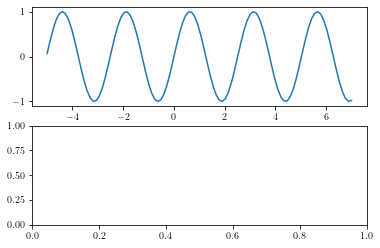

In [3]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(x_test, y_test)

## Last-layer Model

In [4]:
tracking_cols = ["Epoch time", "MSE"]

In [5]:
class EpochTimeStamp:
    def __init__(self):
        self.epoch_start_time = datetime.now()
    
    def get_delta(self):
        return (datetime.now() - self.epoch_start_time).total_seconds()

    def update(self):
        self.epoch_start_time = datetime.now()

In [6]:
torch.manual_seed(3)
lr = 1e-4
ll_vifeature_extractor = FC_Net(layers=[1, 200, 100], nll = torch.nn.Tanh(),lr=lr, weight_decay=0.1)

# dist = Diagonal(100, 1, lr=lr)
dist = FullCovariance(100, 1, lr=lr, init_log_var=-0.5)

llvi_net = LLVIRegression(100, 1, ll_vifeature_extractor, dist, prior_log_var=-6,
tau=0.01, data_log_var=torch.log(torch.tensor([0.04])),
 lr=lr)

In [7]:
@torch.no_grad()
def callback_fun(model, validation_set, n_datapoints, tracking_list, epoch_time_stamp: EpochTimeStamp):
    epoch_time = epoch_time_stamp.get_delta() # get epoch time
    total_loss = 0
    loss_metric = torch.nn.MSELoss(reduction="mean")
    for data, target in validation_set:
        prediction_mean, _ = model(data)
        total_loss += loss_metric(target, prediction_mean).item()
    total_loss/= n_datapoints
    
    tracking_list.loc[len(tracking_list)] = [epoch_time, total_loss]
    epoch_time_stamp.update() # update start time for new epoch


In [8]:
ll_tracking = pd.DataFrame(columns=tracking_cols)
ll_epoch_start = EpochTimeStamp()
llvi_validation_fun = lambda x: callback_fun(llvi_net, validation_set, n_val_datapoints, ll_tracking, ll_epoch_start)
llvi_net.train_model(train_set, epochs=500, n_datapoints=256, method=LikApprox.CLOSEDFORM, callback=llvi_validation_fun);

prediction_loss:0.2 kl_loss:1.72: 100%|██████████| 500/500 [00:47<00:00, 10.45it/s]  


## Full layer model

In [9]:
torch.manual_seed(1)
full_net = nn.Sequential(nn.Linear(1, 200), nn.Tanh(), nn.Linear(200, 100), nn.Tanh(), nn.Linear(100, 1))
prior = tyxe.priors.IIDPrior(pyro_dist.Normal(0, 1))
kl_div_scaling_factor=10
likelihood = tyxe.likelihoods.HomoskedasticGaussian(n_train_datapoints * kl_div_scaling_factor, scale=0.2)
inference = tyxe.guides.AutoNormal
full_bnn = tyxe.VariationalBNN(full_net, prior, likelihood, inference)

In [10]:
full_vi_tracking = pd.DataFrame(columns=tracking_cols)

@torch.no_grad()
def full_layer_val_fun(_, epoch, elbo, epoch_time_stamp: EpochTimeStamp):
    epoch_time = epoch_time_stamp.get_delta()
    if (epoch % 10 ) == 0:
        print(f"Epoch {epoch}, ELBO loss {elbo} ", end="\r")
    total_loss = 0
    loss_metric = torch.nn.MSELoss(reduction="mean")
    for data, target in validation_set:
        prediction_mean, _ = full_bnn.predict(data)
        total_loss += loss_metric(target, prediction_mean).item()
    total_loss/= n_val_datapoints
    full_vi_tracking.loc[len(full_vi_tracking)] = [epoch_time, total_loss]
    epoch_time_stamp.update()
    

In [11]:
optim = pyro.optim.Adam({"lr": 1e-3})
epochs=500
full_epoch_start = EpochTimeStamp()
full_layer_callback = lambda x,y,z: full_layer_val_fun(x,y,z, full_epoch_start)
with tyxe.poutine.local_reparameterization():
    full_bnn.fit(train_set, optim, epochs, callback=full_layer_callback)

## Visualize Predictions

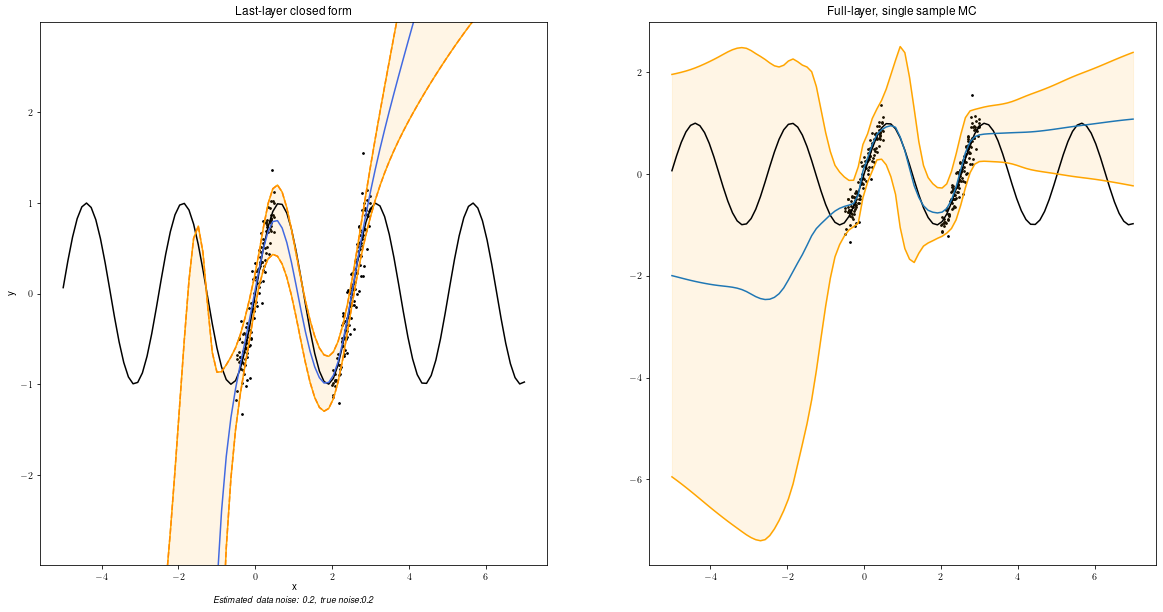

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
visualize_predictions(llvi_net, ax1, x_train, y_train, x_test, y_test, data_noise=data_noise)
ax1.set_title("Last-layer closed form")
ax2.set_title("Full-layer, single sample MC")

with torch.no_grad():
    ax2.plot(x_test, y_test, color="black", label="True function")
    ax2.scatter(x_train, y_train, s=3, color="black")
    mean, std=full_bnn.predict(torch.unsqueeze(x_test, dim=1), num_predictions=100)
    mean = torch.squeeze(mean)
    std = torch.squeeze(std)
    ax2.plot(x_test, mean)
    ax2.plot(x_test, mean+1.96*std, color="orange", label="$+-1.96 \cdot \sigma$")
    ax2.plot(x_test, mean-1.96*std, color="orange")
    ax2.fill_between(torch.squeeze(x_test),mean+1.96*std,mean-1.96*std, alpha=0.1, color="orange")

### MSE vs Time

(0.0, 2.0)

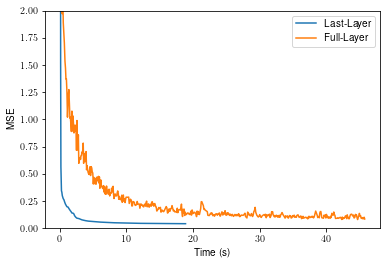

In [15]:
fig, axs = plt.subplots()
axs.plot(ll_tracking["Epoch time"].cumsum(), ll_tracking["MSE"], label="Last-Layer")
axs.plot(full_vi_tracking["Epoch time"].cumsum(), full_vi_tracking["MSE"], label="Full-Layer")
axs.legend()
axs.set_xlabel("Time (s)")
axs.set_ylabel("MSE")
axs.set_ylim(0, 2)

### MSE vs Epoch

(0.0, 2.0)

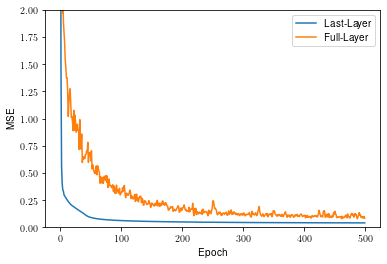

In [16]:
fig, axs = plt.subplots()
axs.plot(list(range(len(ll_tracking))), ll_tracking["MSE"], label="Last-Layer")
axs.plot(list(range(len(full_vi_tracking))), full_vi_tracking["MSE"], label="Full-Layer")
axs.legend()
axs.set_xlabel("Epoch")
axs.set_ylabel("MSE")
axs.set_ylim(0, 2)